### Run the next cell first, to be in the correct direcotry

In [1]:


import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")

Changed to: /Users/maximilianjoas/development/autoencodix_package



## Maskix Dataprep


### 1 Prepare Data
For verificatoin we want to use the same dataset as in the [publication](https://academic.oup.com/bioinformatics/article/40/1/btae020/7564641#438467673). The paper uses 16 datasets, we chose [one](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84133) of those 16. These are in matrix format, we need to convert it to h5ad with scanpy


#### Requirements 
- Downlaod the data from above to `data/raw`
- untar the data, so that how have the files listed in the variable `human_files` below

In [2]:

import pandas as pd
import anndata as ad
import numpy as np

data_path = os.path.join("data/raw/GSE84133_RAW.tar")
root_data = "data/raw/"
# --- 1. Define the Human Input Files ---
human_files = [
    "GSM2230757_human1_umifm_counts.csv.gz",
    "GSM2230758_human2_umifm_counts.csv.gz",
    "GSM2230759_human3_umifm_counts.csv.gz",
    "GSM2230760_human4_umifm_counts.csv.gz",
]
human_files = [os.path.join(root_data, f) for f in human_files]

list_of_adatas_human = []
human_sample_names = ["human1", "human2", "human3", "human4"]


# Corresponding sample names for labeling


print("--- Starting Human Sample Processing ---")

for i, file_path in enumerate(human_files):
    sample_id = human_sample_names[i]
    print(f"Processing {file_path} ({sample_id})...")

    # 1. Load the data (Rows=Cells, Columns=Genes + Metadata)
    # We use low_memory=False to ensure mixed types are read correctly
    df = pd.read_csv(file_path, index_col=0, low_memory=False)

    # 2. SEPARATE Metadata from Counts
    # Select columns that are NOT numbers (e.g., Barcodes, Cell Types)
    df_metadata = df.select_dtypes(exclude=np.number)

    # Select columns that ARE numbers (The gene counts)
    df_counts = df.select_dtypes(include=np.number)

    print(
        f"  -> Found {df_metadata.shape[1]} metadata columns and {df_counts.shape[1]} gene columns."
    )

    # 3. Create AnnData object
    # No transpose needed because the file is already Cells x Genes
    adata = ad.AnnData(
        X=df_counts.values.astype(np.float32),
        obs=df_metadata,  # Add the extracted metadata (Barcodes/CellType) here
        var=pd.DataFrame(index=df_counts.columns),  # Gene names
    )

    # Add the sample identifier
    adata.obs["sample_id"] = sample_id

    list_of_adatas_human.append(adata)
    print(f"  -> Created AnnData: {adata.shape}")

print("\n--- Concatenating Human Samples ---")

# 4. Combine
adata_human_combined = ad.concat(
    list_of_adatas_human,
    join="inner",
    index_unique="_",  # Appends '_1', '_2' to duplicate cell indices if any
)

# 5. Save
output_file = "GSE84133_human_combined.h5ad"
adata_human_combined.write(output_file)

print(f"\nSuccessfully saved combined human data to: {output_file}")
print(adata_human_combined)

--- Starting Human Sample Processing ---
Processing data/raw/GSM2230757_human1_umifm_counts.csv.gz (human1)...
  -> Found 2 metadata columns and 20125 gene columns.
  -> Created AnnData: (1937, 20125)
Processing data/raw/GSM2230758_human2_umifm_counts.csv.gz (human2)...
  -> Found 2 metadata columns and 20125 gene columns.
  -> Created AnnData: (1724, 20125)
Processing data/raw/GSM2230759_human3_umifm_counts.csv.gz (human3)...
  -> Found 2 metadata columns and 20125 gene columns.
  -> Created AnnData: (3605, 20125)
Processing data/raw/GSM2230760_human4_umifm_counts.csv.gz (human4)...
  -> Found 2 metadata columns and 20125 gene columns.
  -> Created AnnData: (1303, 20125)

--- Concatenating Human Samples ---

Successfully saved combined human data to: GSE84133_human_combined.h5ad
AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'barcode', 'assigned_cluster', 'sample_id'


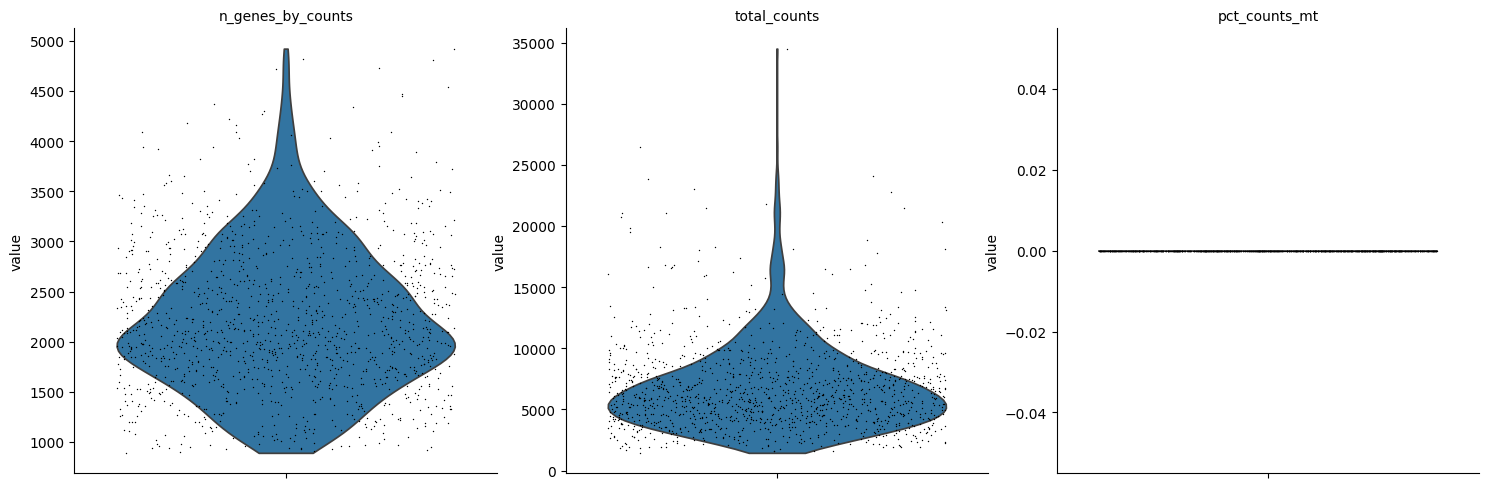

In [3]:

import scanpy as sc

# 1. Calculate QC metrics (percentage of mitochondrial genes, number of genes per cell)
# Note: Human mitochondrial genes start with "MT-", Mouse with "mt-"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# 2. Visualize quality
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# 3. Filter (Standard "Downstream" Preprocessing)
# These thresholds are examples; adjust based on the violin plots above
adata = adata[adata.obs.n_genes_by_counts < 2500, :]  # Remove doublets
adata = adata[
    adata.obs.pct_counts_mt < 10, :
]  # Remove dying cells (adjust to 5% or 20% based on data)

In [4]:

adata.obs["assigned_cluster"].value_counts()

assigned_cluster
beta                  338
alpha                 236
ductal                136
delta                  88
gamma                  58
activated_stellate     27
endothelial             7
quiescent_stellate      3
macrophage              2
acinar                  1
epsilon                 1
mast                    1
schwann                 1
t_cell                  1
Name: count, dtype: int64

In [5]:

# Assuming your combined object is named 'adata_human_combined'
sc_path = os.path.join("data/raw", "GSE84133_human_combined_final.h5ad")

adata_human_combined.write(output_file)

print(f"✅ Data successfully saved to: {output_file}")

✅ Data successfully saved to: GSE84133_human_combined.h5ad
